# Microjax: Jax in 100 Lines of Code

## Introduction / Demo

This is inspired by Andrej Karpathy's [Micrograd](https://github.com/karpathy/micrograd/tree/master)


Disclaimer: most of this is shamelessly copied from Matthew J Johnson's presentation
* https://videolectures.net/deeplearning2017_johnson_automatic_differentiation/
* https://www.cs.toronto.edu/~duvenaud/talks/Johnson-Automatic-Differentiation.pdf
* https://github.com/mattjj/autodidact

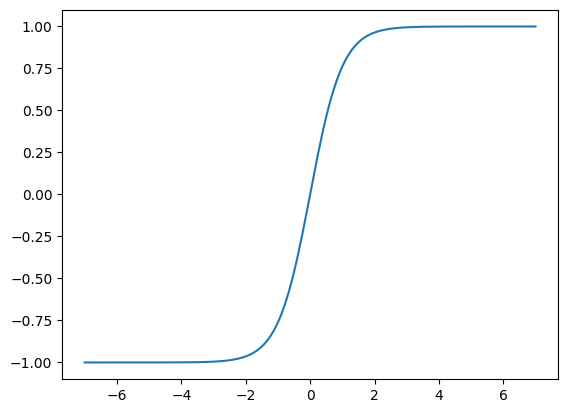

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import microjax
from microjax import anp, grad, toposort, Box, add_outgrads, find_top_boxed_args

x = np.linspace(-7, 7, 200)
_ = plt.plot(
    x, anp.tanh(x),
    # x, grad(anp.tanh)(x),
    # x, grad(grad(anp.tanh))(x),
    # x, grad(grad(grad(anp.tanh)))(x),
    # x, grad(grad(grad(grad(anp.tanh))))(x), 
    # x, grad(grad(grad(grad(grad(anp.tanh)))))(x),
    # x, grad(grad(grad(grad(grad(grad(anp.tanh))))))(x),
)

## Theory: Jacobians, Chain Rule, Forward- and Reverse-Mode

Assume we have some function `F`, which evaluates a vector and returns a scalar.

Furthermore, assume `F` is the composition of some other functions, `A`, `B`, `C`, and `D`.

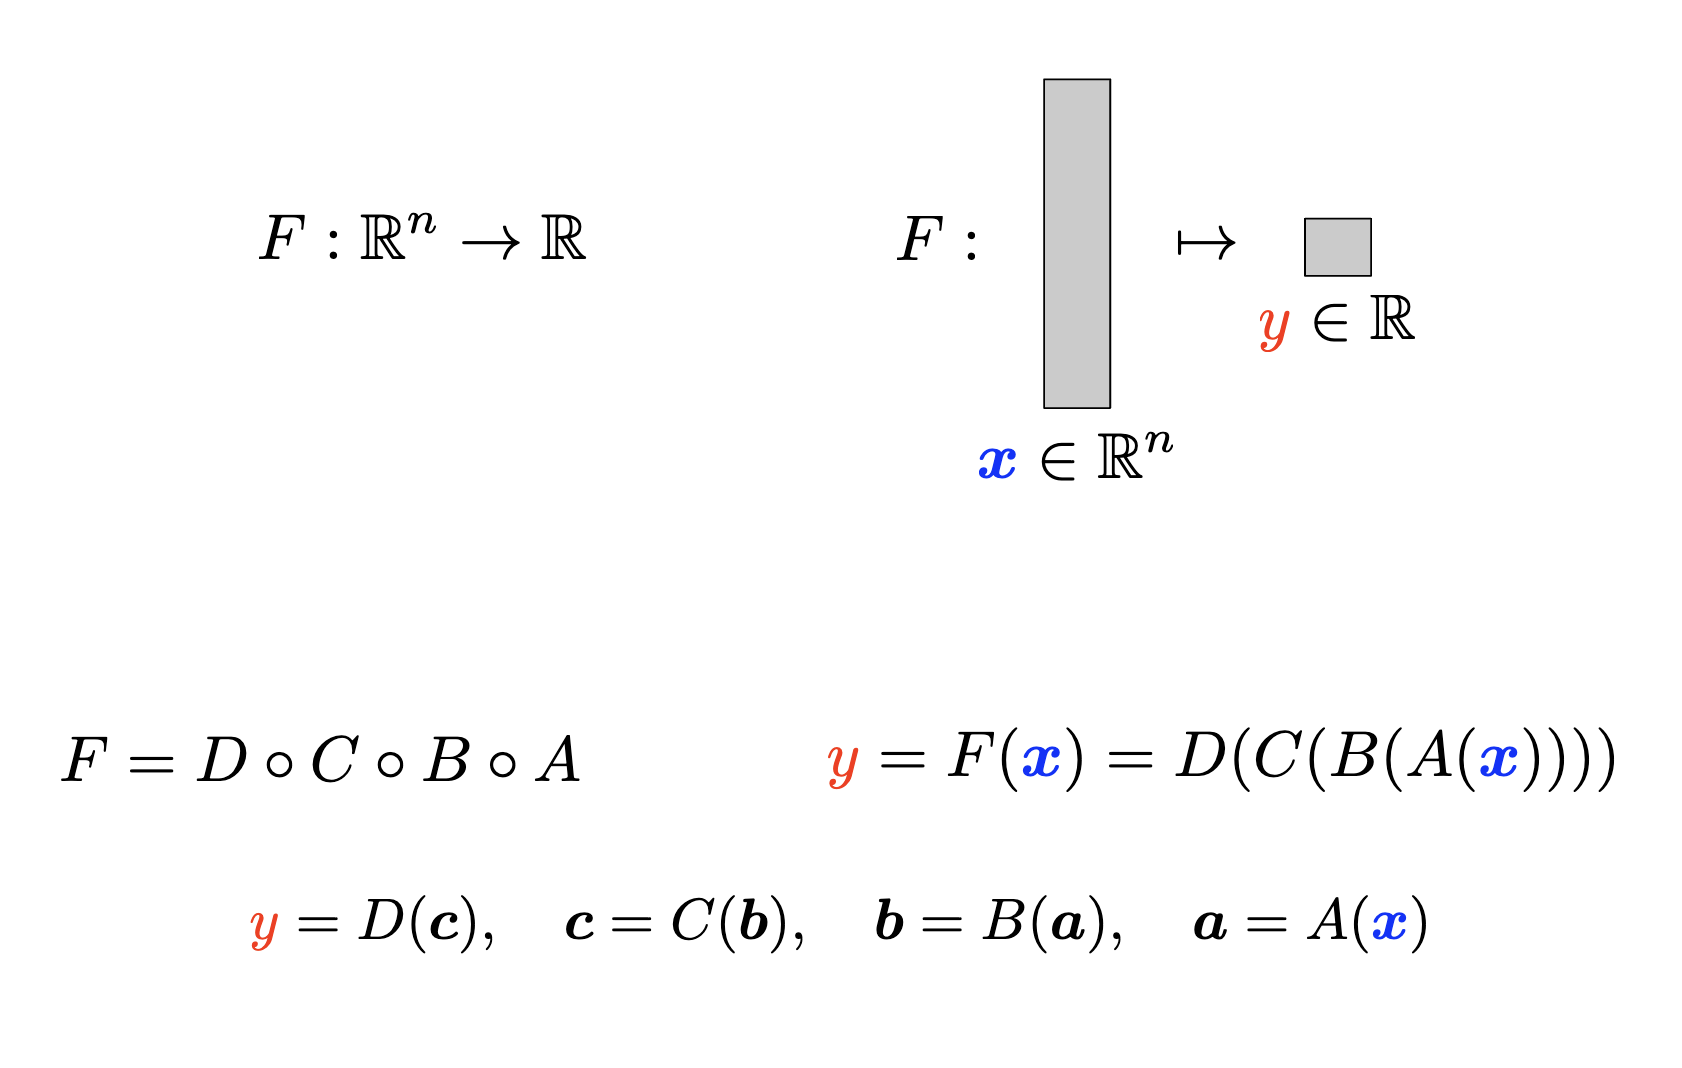

We want to evaluate the derivative of `F`.

We write `F'(x)` for the Jacobian matrix of `F` evaluated at `x`. This is a matrix of partial derivatives. In this case it's just one row (because `F` has a scalar output, with a vector input).

The chain rule tells us that we can write the Jacobian `F'(x)` as the product of the other Jacobian matrices.

What are the sizes of the matrices? (width of output x width of input: 1 x size of C, size of C x size of B, etc)

Does the order of multiplication matter?

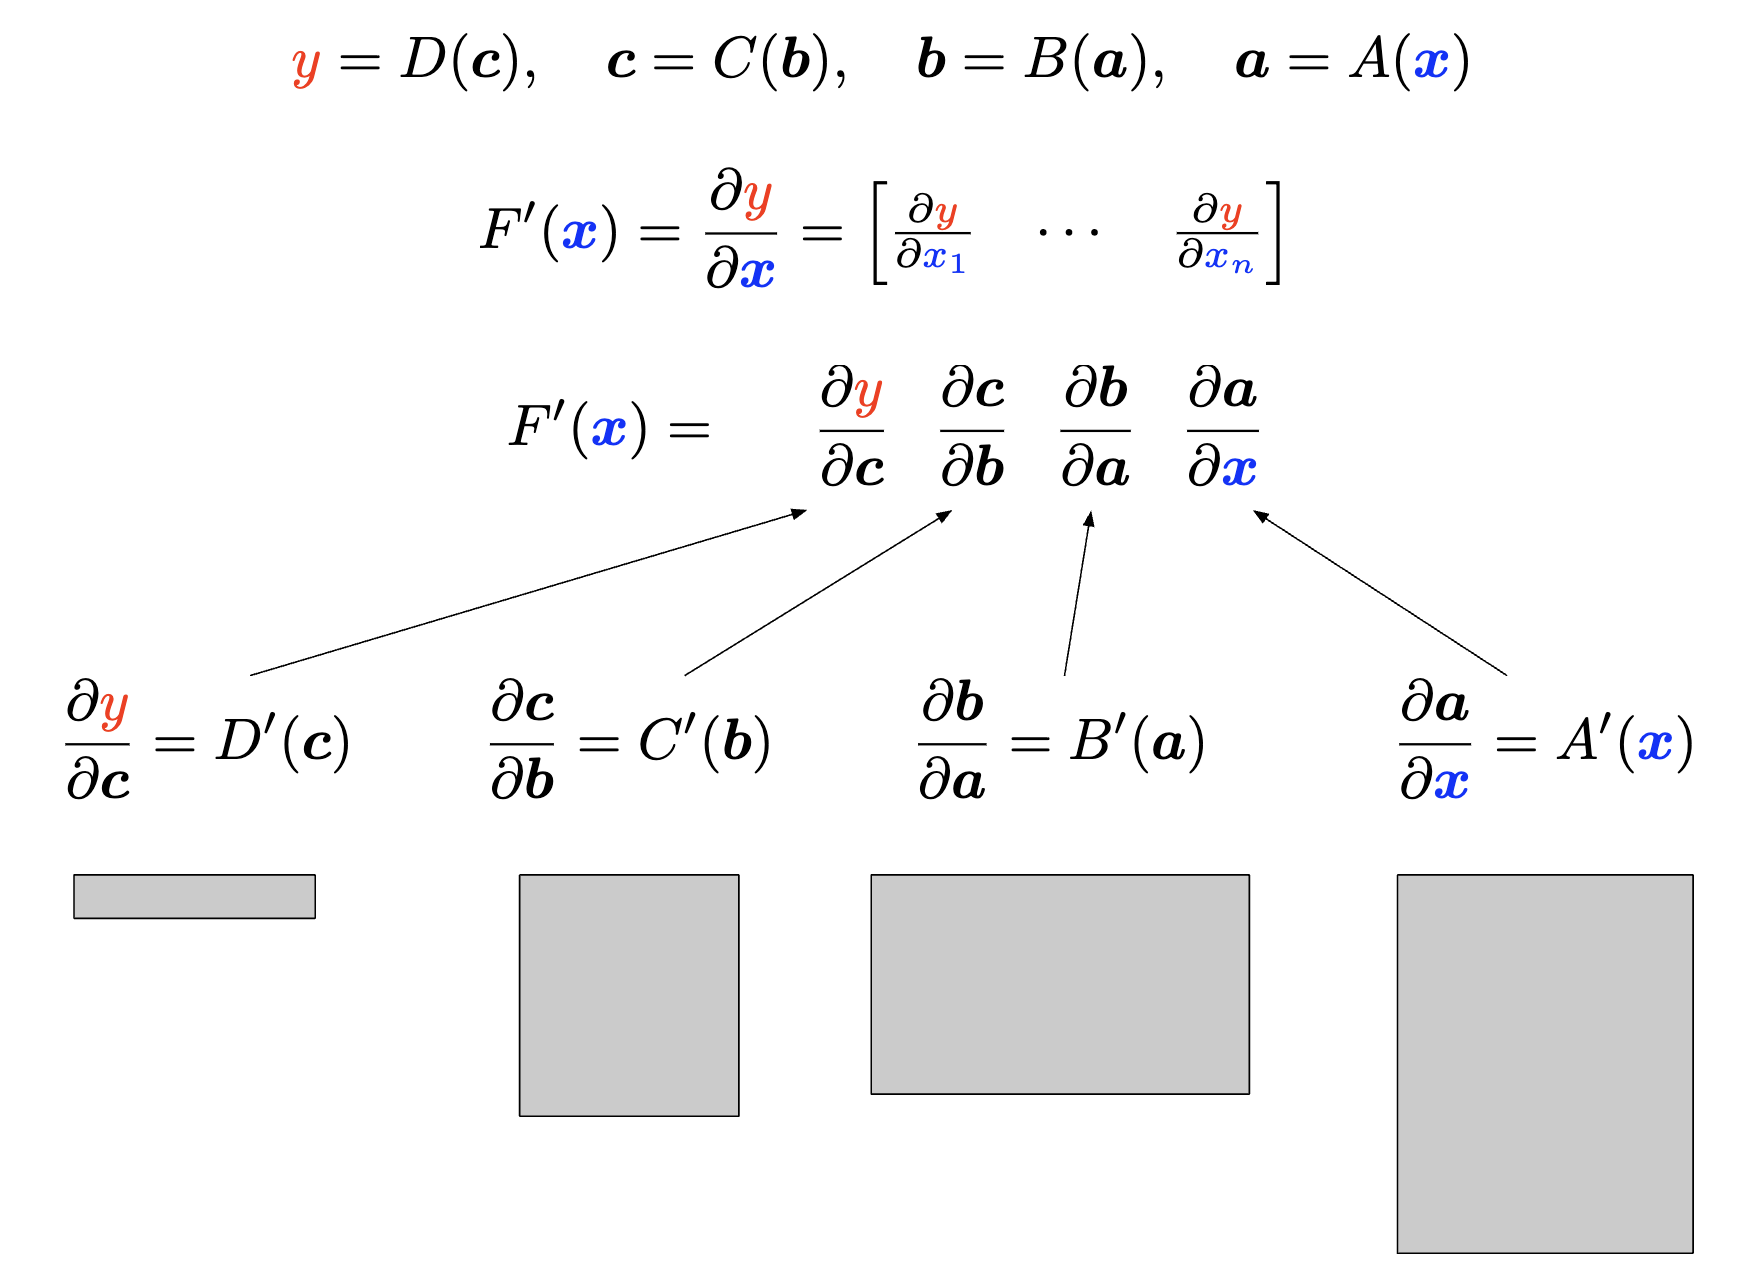

Two ways of multiplying matrices.

Forward accumulation: all intermediate matrices are something by the size of x.

Reverse accumulation: all intermediate matrices are 1 by something.

Because we're usually working with scalar outputs, reverse accumulation is typically much more efficient.

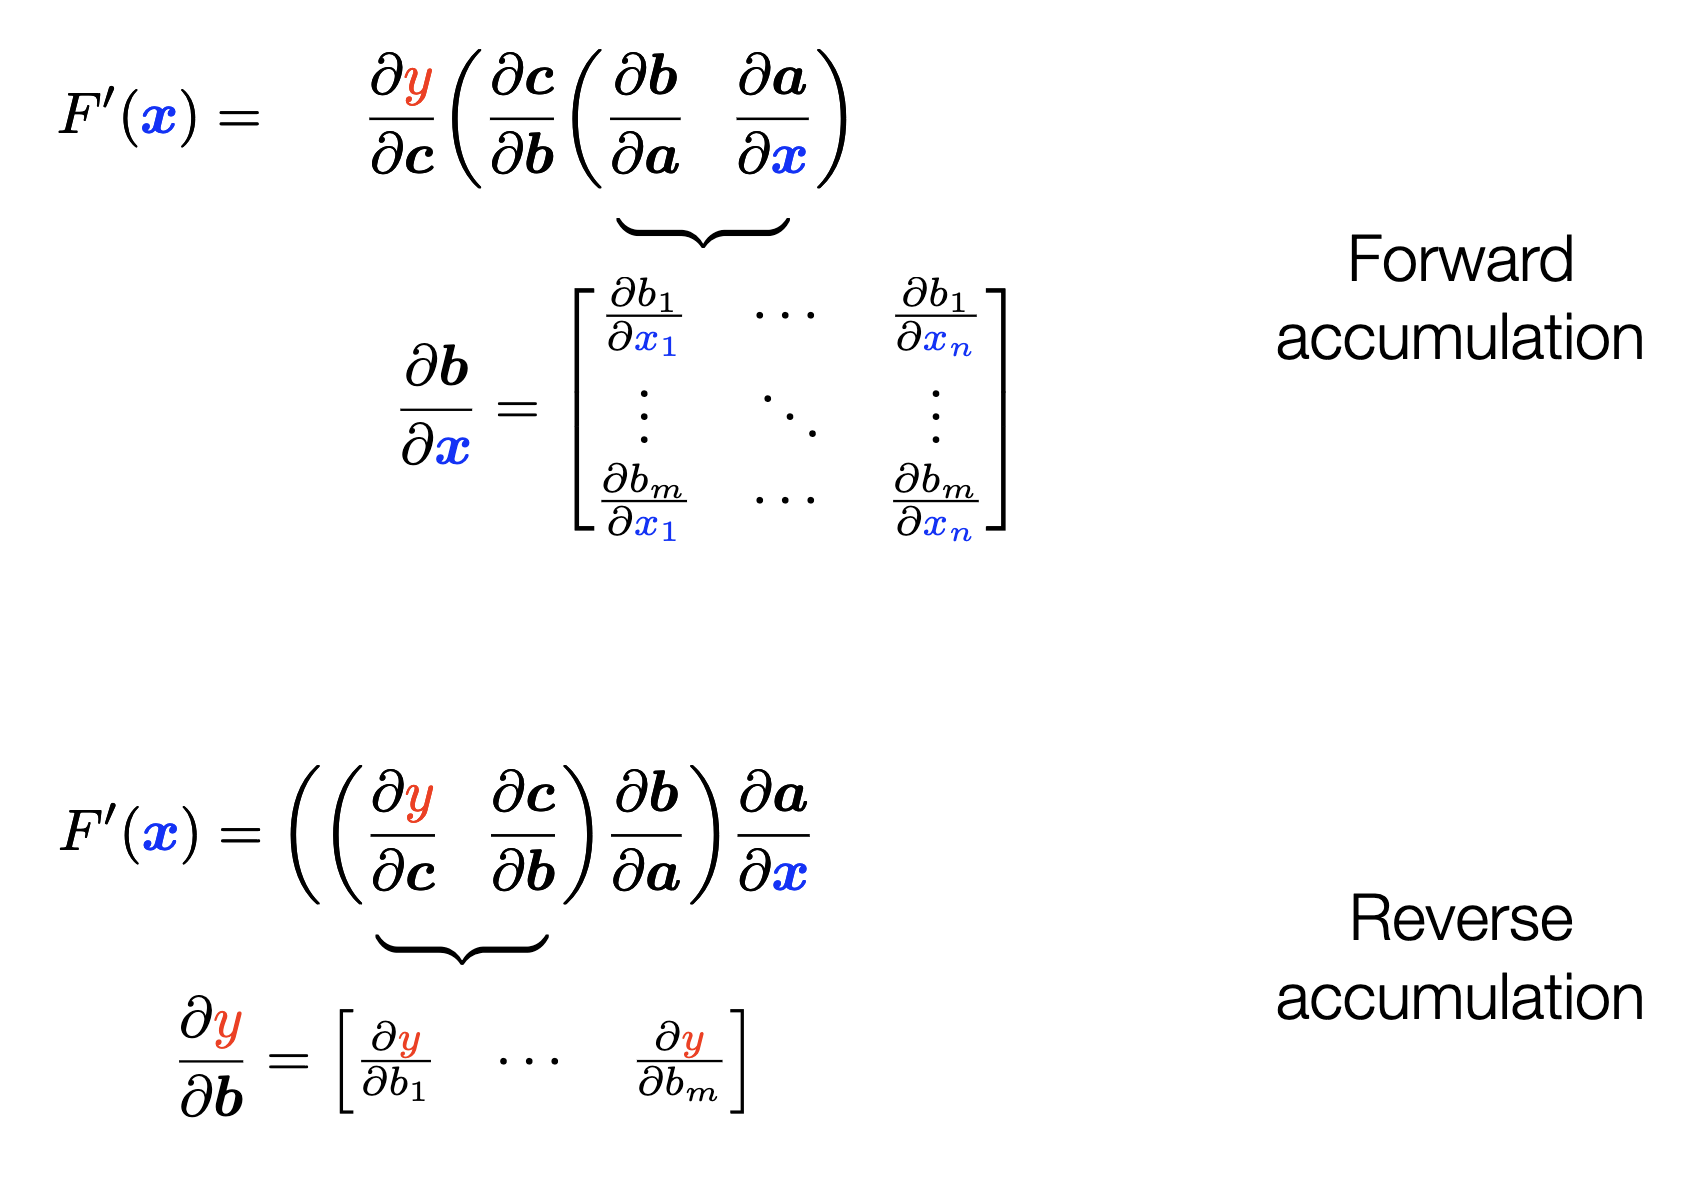

One thing we might want to do is, instead of building the entire Jacobian matrix, make a function which returns it multiplied by some vector.

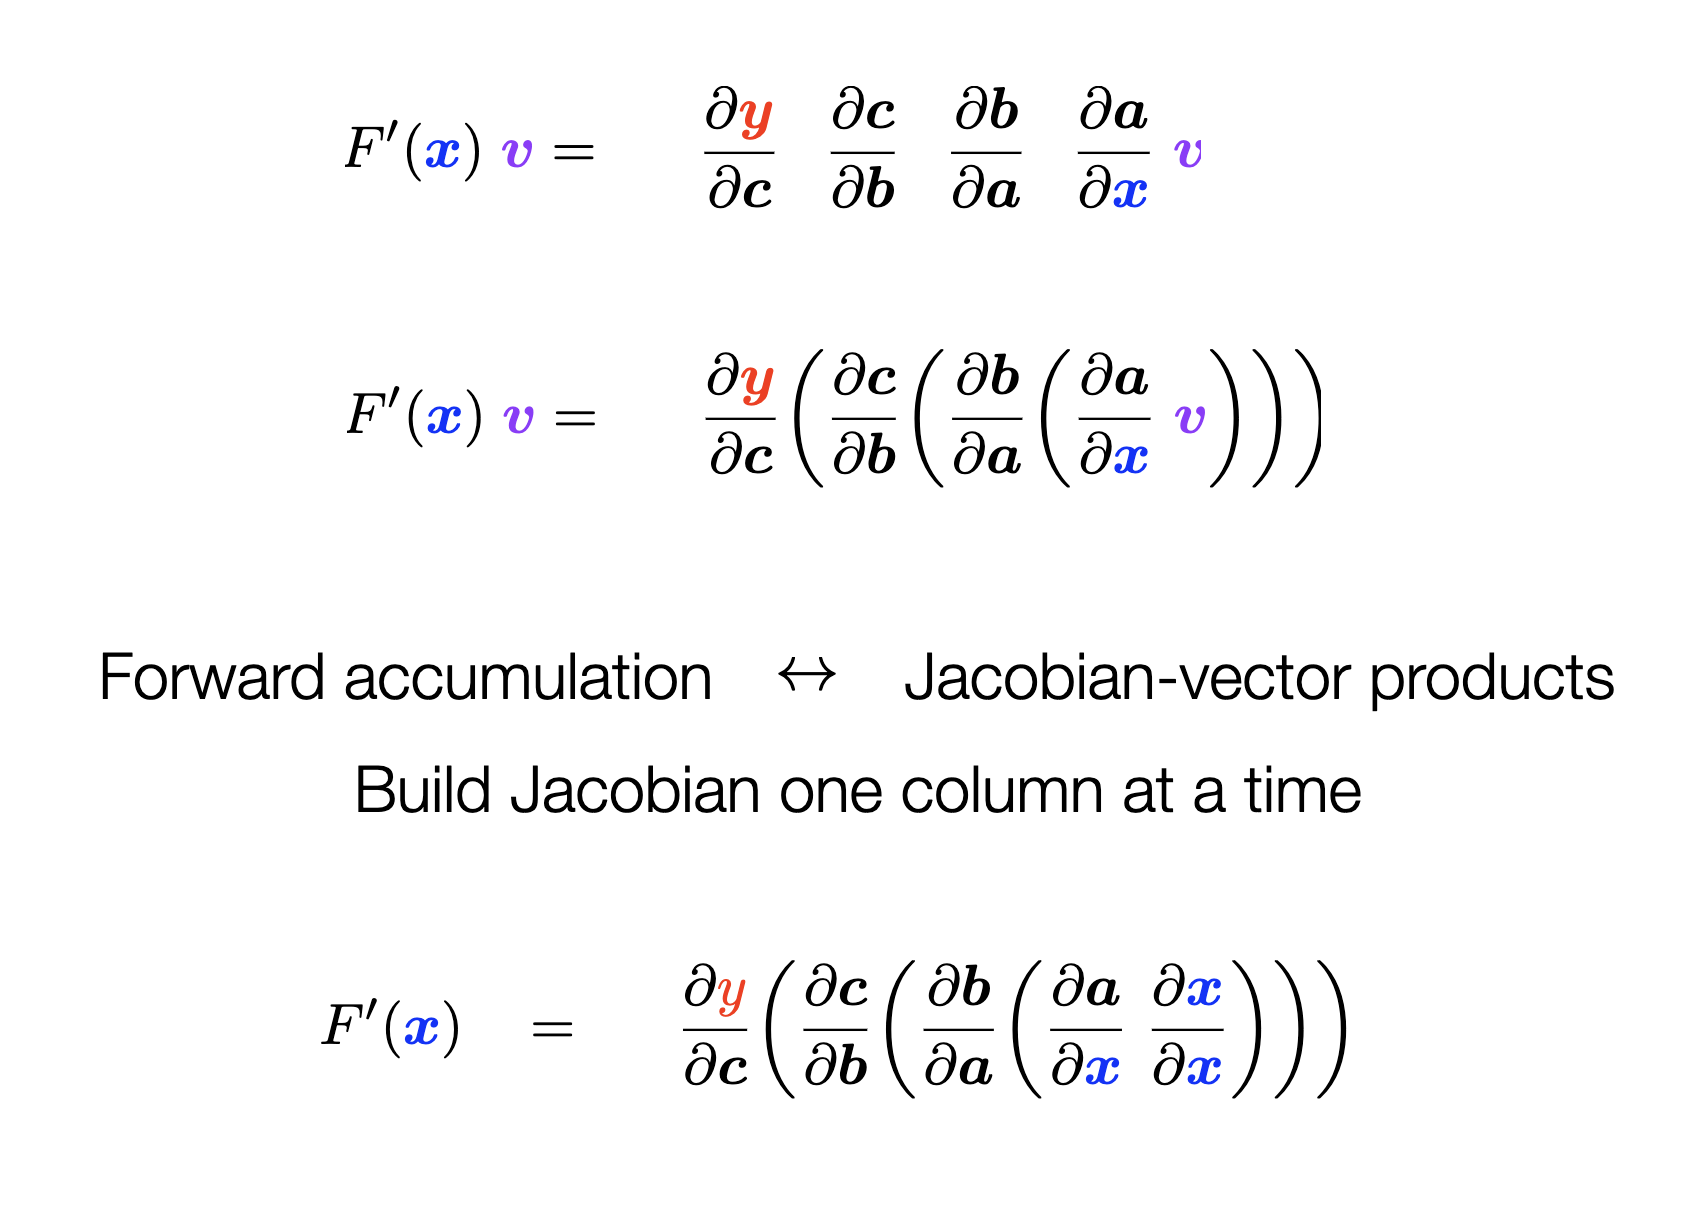

Another thing we can do is multiply the vector on the left.

In ML we always have loss functions which go from `R^N -> R`, so the Jacobian is always a `1 x N` matrix (where N may be in the billions)! Since reverse mode builds the Jacobian one row at a time, you're done in one call! With forward mode it would take N calls. (each of these calls is comparable to the cost of calling the function)

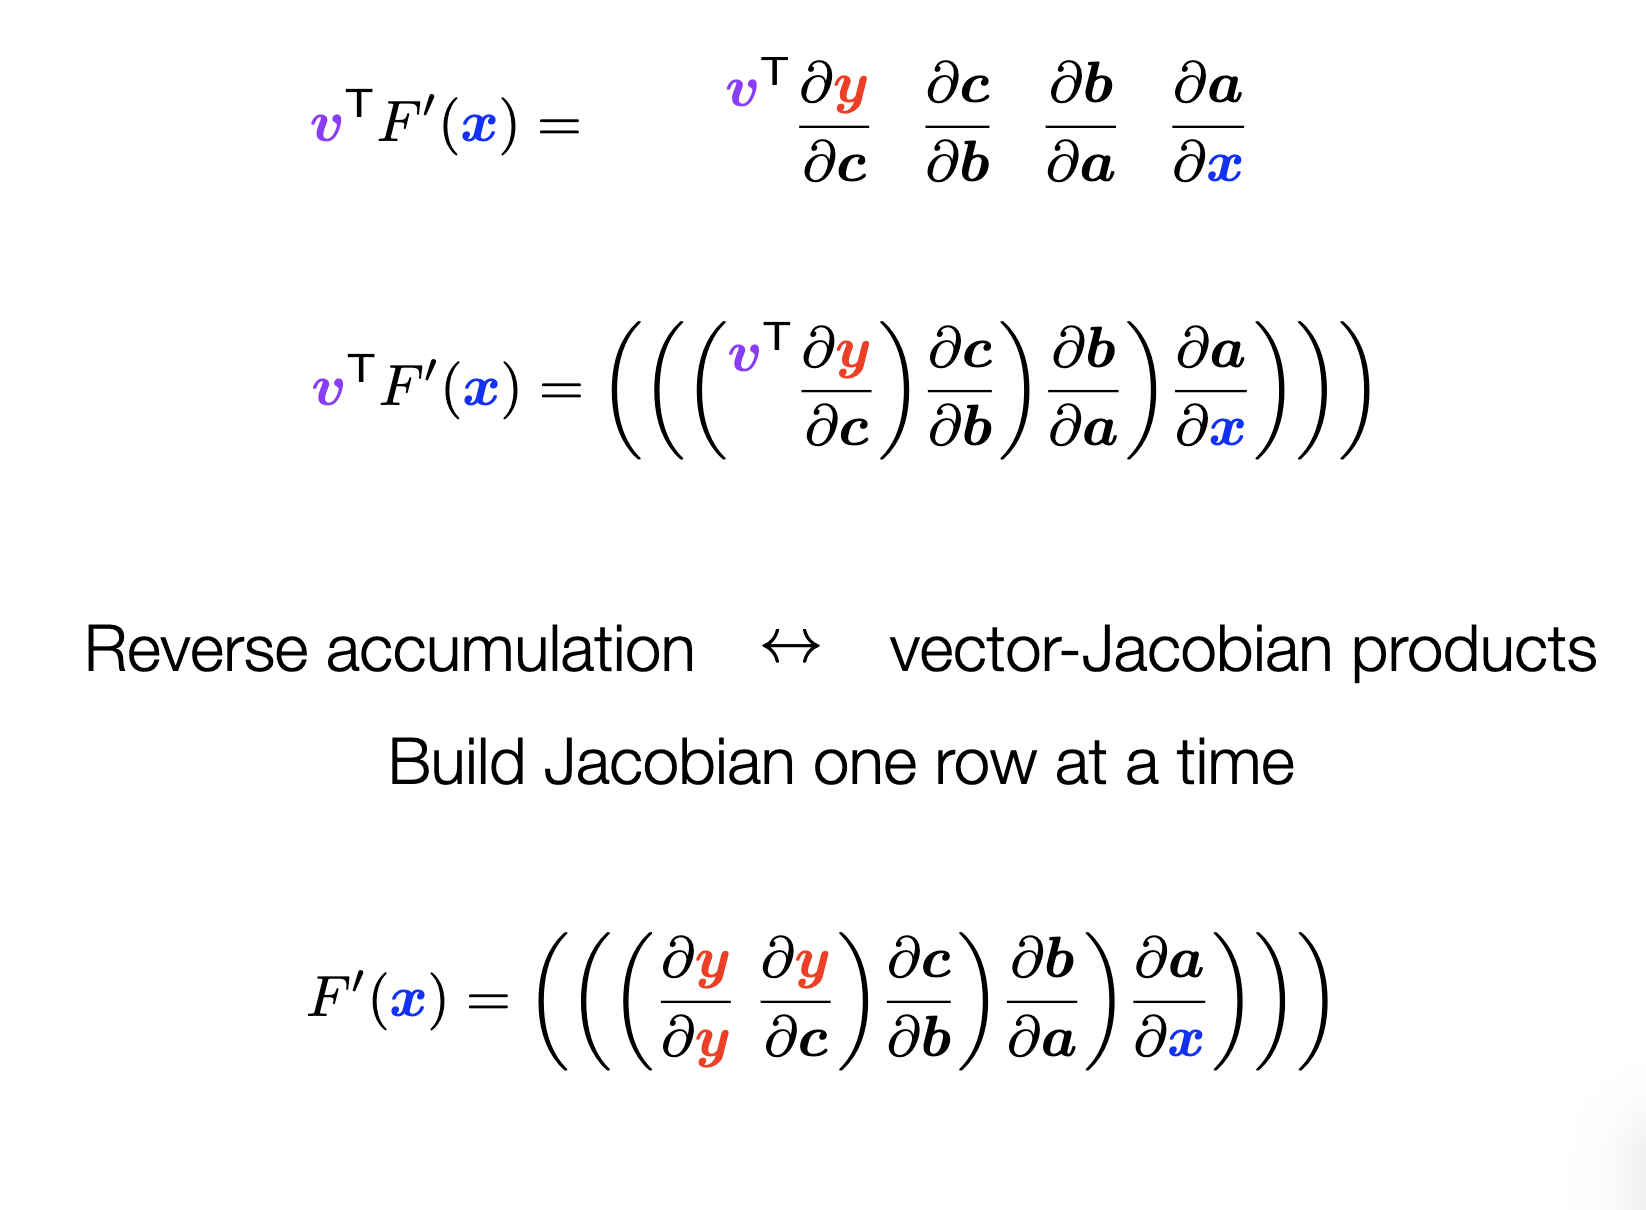

## Implementation

Jax works the same way as Pytorch in one respect -- both record / trace the execution of the program at runtime and use it to build a graph.

Three ingredients:
1. Tracing the composition of primitive functions
2. Defining a vector-Jacobian product (VJP) for each primitive
3. Composing VJPs backward

### Tracing

Wrap each Numpy function in a primitive which boxes and unboxes values.

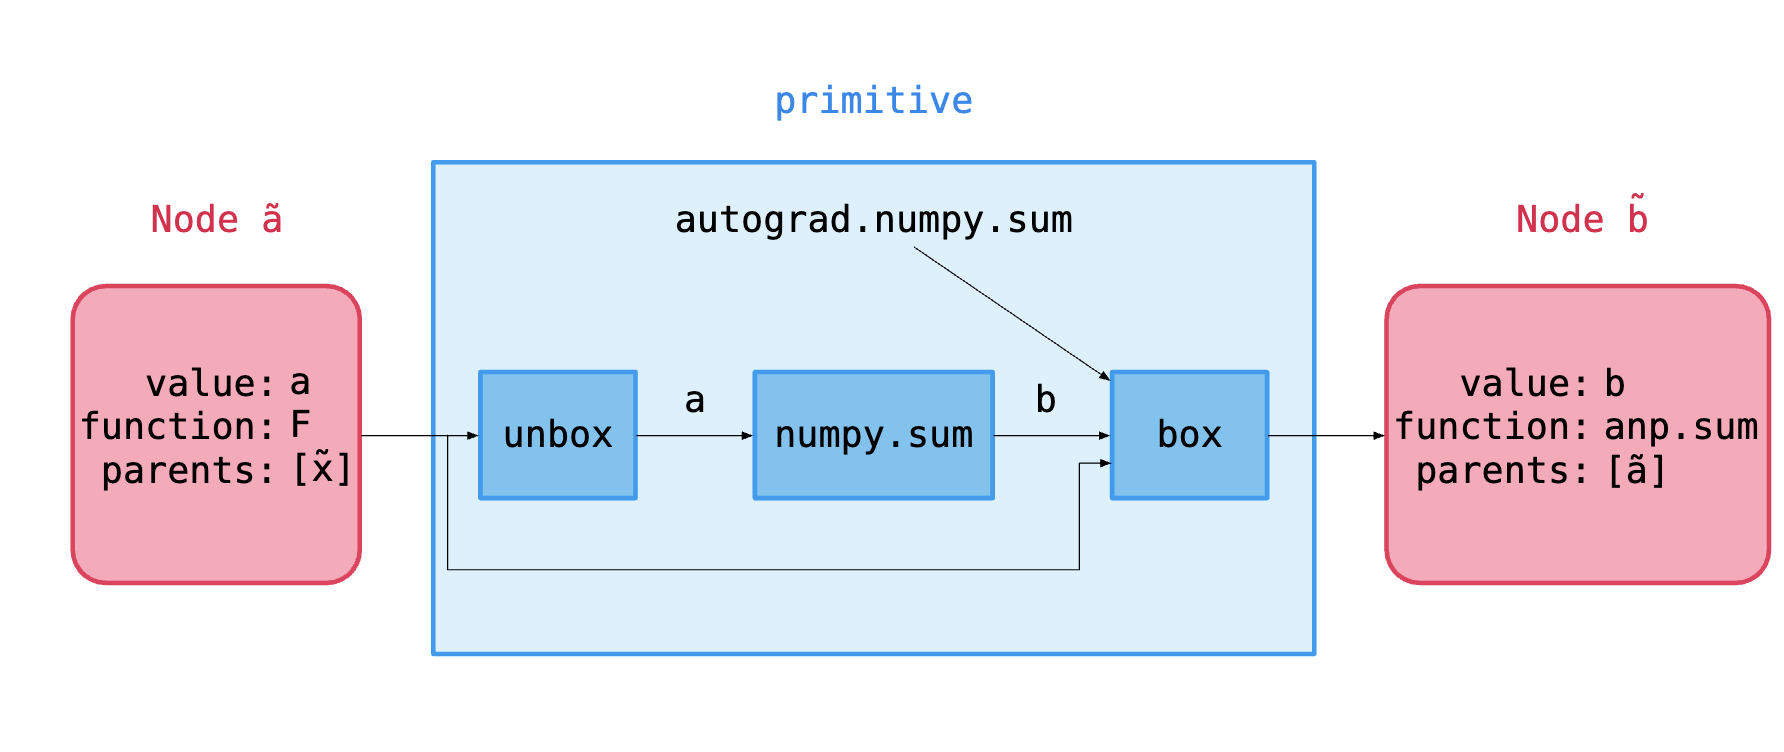

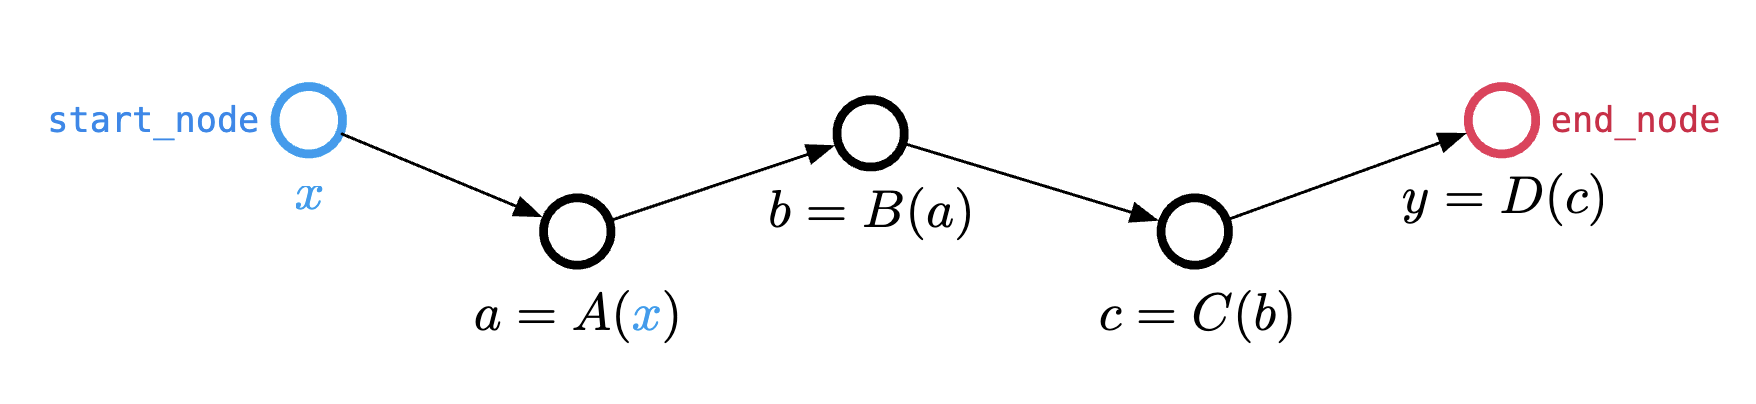

Also works with DAGs

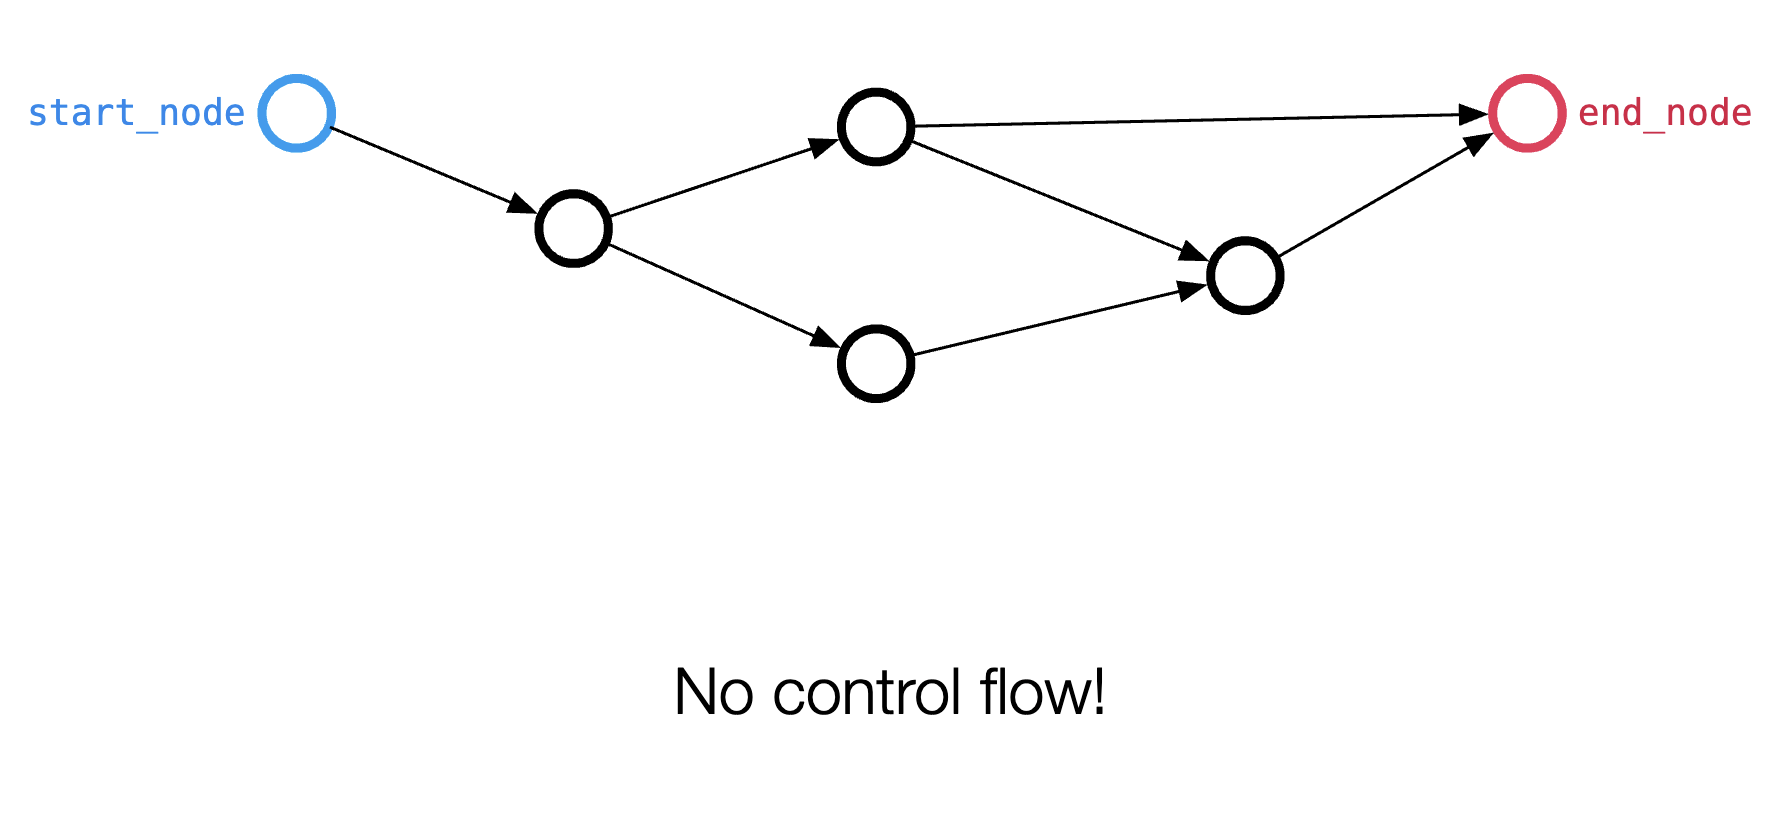

What happens to a loop (or any control flow) in user code? (it gets unrolled)

In [2]:
class Node(object):
    def __init__(self, value, fun, args, kwargs, parent_argnums, parents):
        self.parents = parents
        self.recipe = (fun, value, args, kwargs, parent_argnums)

    def initialize_root(self):
        self.parents = []
        self.recipe = (lambda x: x, None, (), {}, [])

    @classmethod
    def new_root(cls, *args, **kwargs):
        root = cls.__new__(cls)
        root.initialize_root(*args, **kwargs)
        return root

In [3]:
def primitive(f_raw):
    """Wraps a function so that its gradient (vjp) can be specified and its
    invocation can be recorded."""

    def f_wrapped(*args, **kwargs):
        # Fetch boxed arguments with largest trace_id.  This ensures that the
        # computational graph being constructed only consists of other nodes
        # from the same call to trace().
        boxed_args, trace_id = find_top_boxed_args(args)
        
        if boxed_args:
            argvals = list(args)
            for argnum, box in boxed_args:
                argvals[argnum] = box._value

            parents = tuple(box._node for _, box in boxed_args)
            argnums = tuple(argnum for argnum, _ in boxed_args)
            ans = f_wrapped(*argvals, **kwargs)
            node = Node(ans, f_wrapped, argvals, kwargs, argnums, parents)
            return Box(ans, trace_id, node)
        else:
            return f_raw(*args, **kwargs)

    return f_wrapped

In [4]:
trace_id = 0

def trace(start_node, fun, x):
    """(forward pass / build computation graph)"""
    global trace_id
    trace_id += 1
    try:
        start_box = Box(x, trace_id, start_node)
        end_box = fun(start_box)

        if isinstance(end_box, Box) and end_box._trace_id == start_box._trace_id:
            return end_box._value, end_box._node
        else:
            # Output seems independent of input
            return end_box, None
    finally:
        trace_id -= 1

In [5]:
class Anp:
    def __init__(self):
        self.negative = primitive(np.negative)
        self.exp = primitive(np.exp)
        self.log = primitive(np.log)
        self.multiply = primitive(np.multiply)
        self.add = primitive(np.add)

anp = Anp()

### VJPs

We have derivative information with respect to the output (a) and we want to pull it back to be with respect to x.

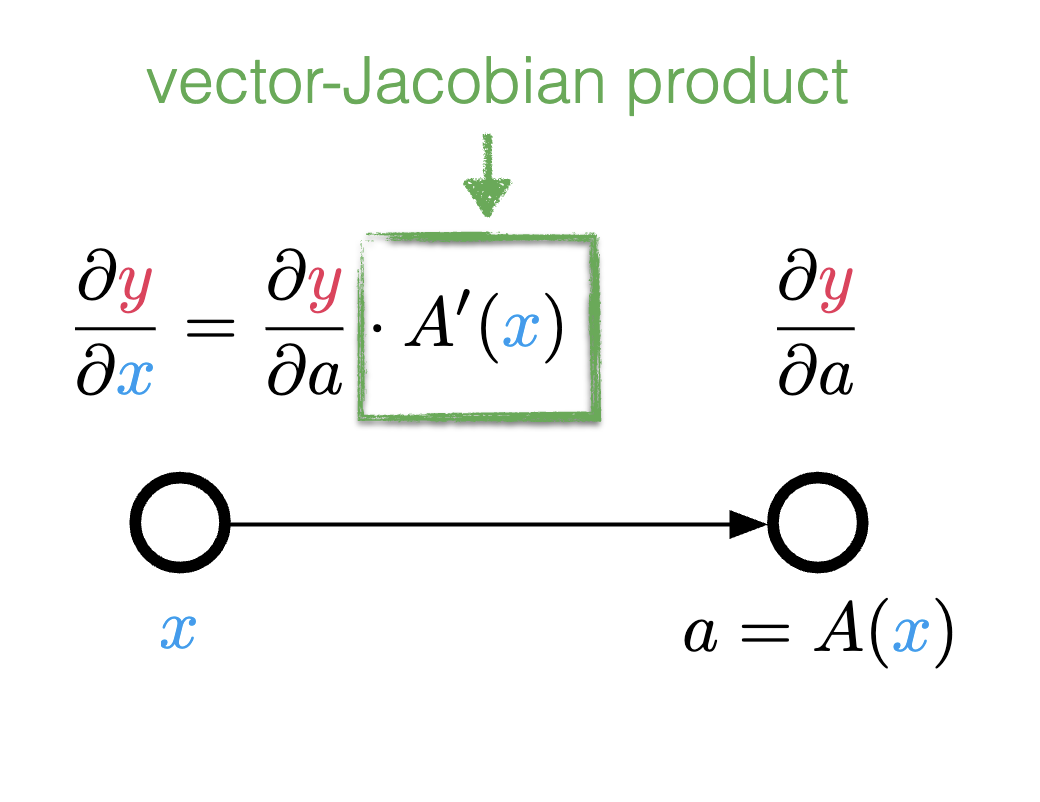

In [6]:
# g is the gradient we want to pull back
# ans is the output, a
# x is the input
primitive_vjps = {
    anp.negative: {0: lambda g, ans, x: -g},
    anp.add: {
        0: lambda g, ans, x, y: g,
        1: lambda g, ans, x, y: g,
    },
    anp.multiply: {
        0: lambda g, ans, x, y: y * g,
        1: lambda g, ans, x, y: x * g,
    },
    anp.exp: {0: lambda g, ans, x: ans * g},
    anp.log: {0: lambda g, ans, x: g / x},
}

### Composing VJPs Backward

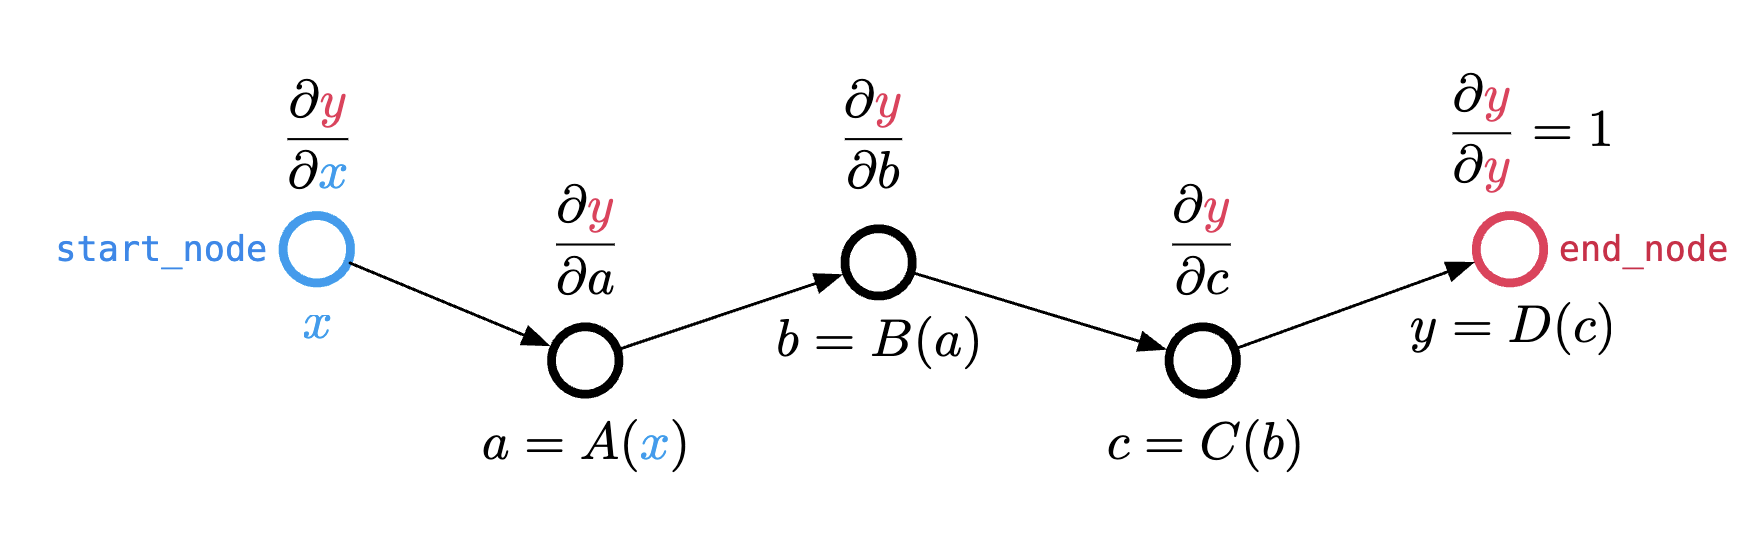

The backward pass is itself traceable! This is how higher-order autodiff (`grad(grad)`) works.

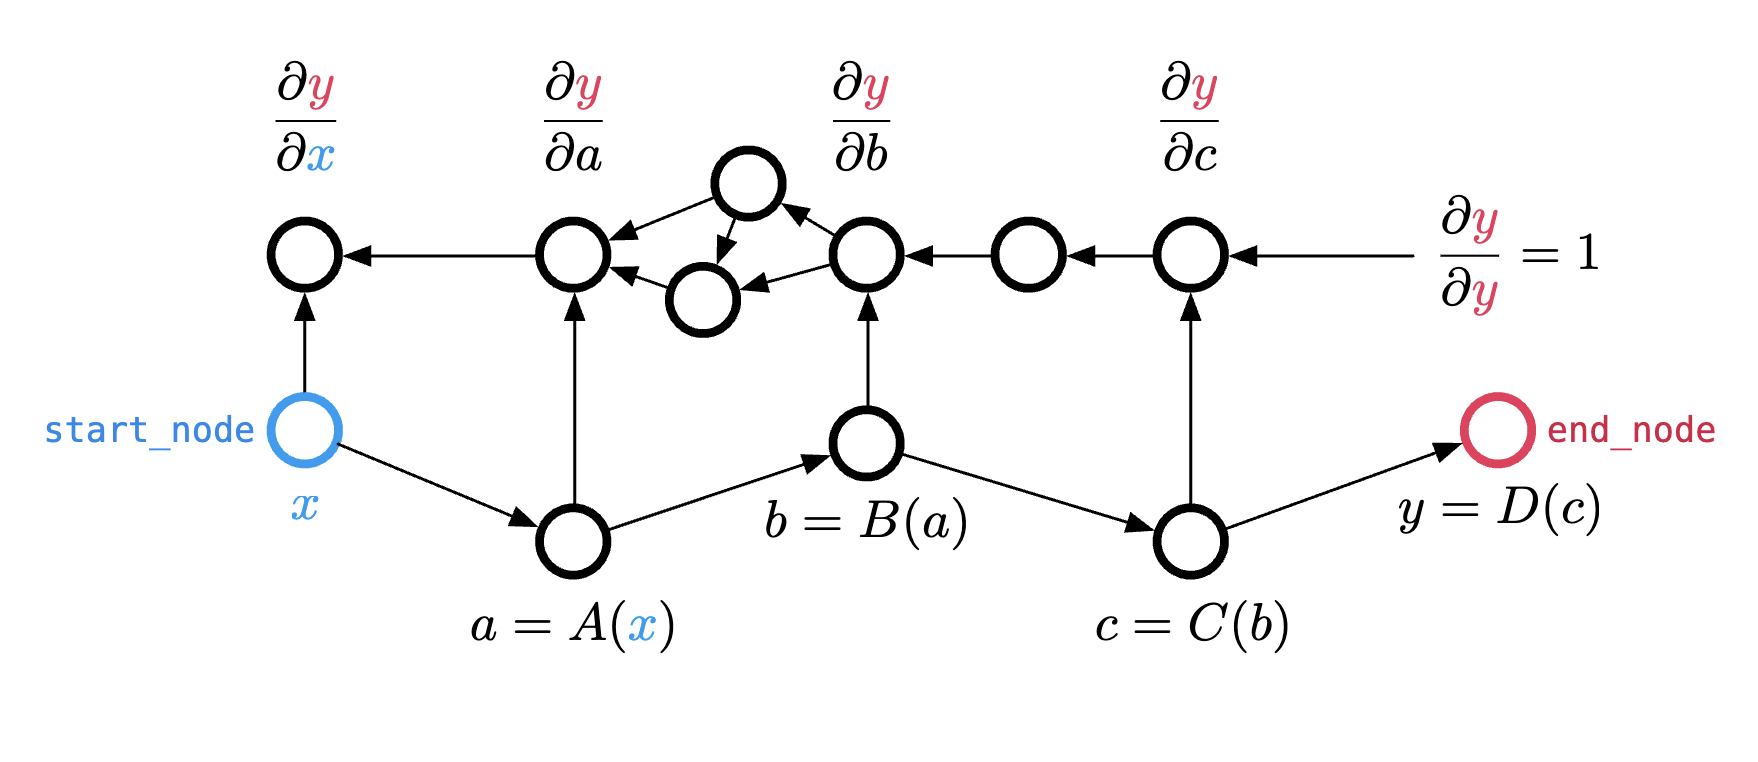

In [7]:
anp = microjax.anp
primitive_vjps = microjax.primitive_vjps

In [8]:
def backward_pass(g, end_node):
    outgrads = {end_node: g}
    for node in toposort(end_node):
        outgrad = outgrads.pop(node)
        fun, value, args, kwargs, argnums = node.recipe
        for argnum, parent in zip(argnums, node.parents):
            vjp = primitive_vjps[fun][argnum]
            parent_grad = vjp(outgrad, value, *args, **kwargs)
            outgrads[parent] = add_outgrads(outgrads.get(parent), parent_grad)
    return outgrad

In [9]:
# from primitive VJPs make a composite VJP for this function
def make_vjp(fun, x):
    start_node = Node.new_root()
    end_value, end_node = trace(start_node, fun, x)

    if end_node is None:
        def vjp(g):
            return np.zeros_like(x)

    else:
        def vjp(g):
            return backward_pass(g, end_node)

    return vjp, end_value

In [10]:
def grad(fun, argnum=0):
    def gradfun(*args, **kwargs):
        # Replace args[argnum] with x. Define a single-argument function to
        # compute derivative wrt.
        def unary_fun(x):
            new_args = list(args)
            new_args[argnum] = x
            return fun(*new_args, **kwargs)

        # Construct vector-Jacobian product
        vjp, ans = make_vjp(unary_fun, args[argnum])
        return vjp(np.ones_like(ans))

    return gradfun

### Testing

In [11]:
grad(anp.exp)(np.array([1.,2.,3.]))

array([ 2.71828183,  7.3890561 , 20.08553692])

In [12]:
grad(lambda x: anp.exp(x) + anp.log(x))(np.array([1.,2.,3.]))

array([ 3.71828183,  7.8890561 , 20.41887026])

In [13]:
def f(x):
    import random
    return anp.exp(x) if random.random() < 0.5 else anp.log(x)

grad(f)(np.array([1.,2.,3.]))

array([ 2.71828183,  7.3890561 , 20.08553692])

In [14]:
def f(x):
    for i in range(5):
        x = anp.log(x + i)
    return x

grad(f)(np.array([1.,2.,3.]))

array([0.02551332, 0.00554491, 0.00268263])

### Summary

Three ingredients:

1. Tracing the composition of primitive functions
   `Node`, `primitive`, `trace`
2. Defining a vector-Jacobian product (VJP) for each primitive
   `primitive_vjps`
3. Composing VJPs backward
   `backward_pass`, `make_vjp`, `grad`